In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import pandas as pd
import json
import importlib
sys.path.insert(0, '../utils')
import data_utils, run_utils, models

#### WNET

In [9]:
'''
Quickly summarize trained models
    TODO: rename 
        For input info changes: flux=X (29,31), time_series=T (34), mag=M
        For feat changes: _A, _B (e.g. med vs med**2 TS 40_5 vs 20_5)
        For train params (loss term wght, loss chan wght, lr) changes: _1, _2, etc 
        For model params (pad and kernel size) changes: _a, _b, etc 
        Add subfolders to seperate DS used 
        E.g.
            WNet29nm --> muram_n/WNetX_A1
            WNet29nm_a --> muram_n/WNetX_A2
            WNet32nm --> muram_n/WNetX_B1
            WNet32nm_a --> muram_n/WNetX_B2
            WNet33nm --> muram_n/WNetX_A1a
            WNet34nm --> muram_n/WNetT_A1
            WNet34nm_a --> muram_n/WNetT_A2
            WNet34nm_b --> muram_n/WNetT_A3
        If end up doing model thats predict mag + do seg call it MNet  
'''
importlib.reload(run_utils)
mods = run_utils.get_modelsDF(taskdir='../../WNet_runs')
mods

Skipping exp35nm_c; not finished training
Skipping exp30nm; no exp_file found


,WNet_name,n_classes,channels,smooth_loss,blob_loss,smooth_wght,blob_wght,ncut_wght,padding_mode,num_epochs,learning_rate
11,WNet29nm,3,[X],True,False,10,0.0,1,zeros,10,0.100
12,WNet29nm_a,3,[X],True,False,10,0.0,1,zeros,10,0.001
9,WNet29nm_b,3,[X],True,False,10,0.0,1,replicate,10,0.001
5,WNet31nm,3,"[X, MedRes]",True,False,10,0.0,1,reflect,10,0.100
2,WNet31nm_a,3,"[X, MedRes]",True,False,10,0.0,1,reflect,10,0.001
1,WNet32nm,3,"[X, MedRes]",True,False,10,0.0,1,replicate,10,0.100
8,WNet32nm_a,3,"[X, MedRes]",True,False,10,0.0,1,replicate,10,0.001
4,WNet34nm,3,[TS40_5],True,False,10,0.0,1,replicate,10,0.100
3,WNet34nm_a,3,[TS40_5],True,True,10,1.0,1,replicate,10,0.100
10,WNet34nm_b,3,[TS40_5],True,True,10,10.0,1,replicate,10,0.100


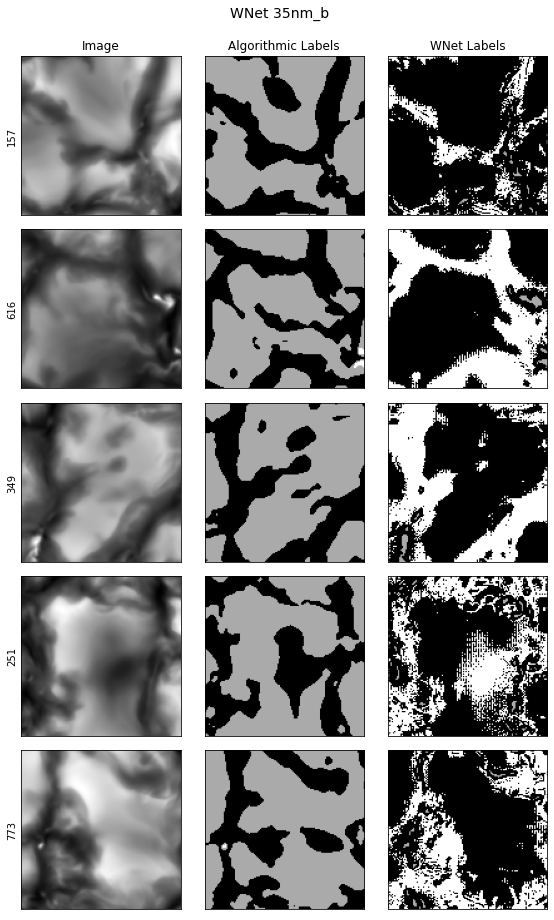

In [6]:
'''
Display a random sample of images for one model
'''

WNet_num = '35nm_b' 
output_dir = f'../../WNet_runs/exp{WNet_num}/test_preds_MURaM'
fig, axs = plt.subplots(5, 3, figsize=(8, 13))
axs[0,0].set_title('Image')
axs[0,1].set_title('Algorithmic Labels')
axs[0,2].set_title('WNet Labels')
target_pos = 2 if 'timeseries' in mods[mods['WNet_name']==f"WNet{WNet_num}"] else 0
for i in range(5): 
    idx = np.random.randint(0, len([file for file in os.listdir(output_dir) if file.startswith('x')]))
    im = np.load(f'{output_dir}/x_{idx}.npy')[target_pos]
    true = np.load(f'{output_dir}/true_{idx}.npy')
    preds = np.squeeze(np.load(f'{output_dir}/pred_{idx}.npy'))
    axs[i,0].imshow(im, cmap='gist_gray'); axs[i,0].set_ylabel(idx)
    axs[i,1].imshow(true, vmin=0, vmax=1.5, cmap='gist_gray')
    axs[i,2].imshow(preds, vmin=0, vmax=1.5, cmap='gist_gray')
    axs[i,0].xaxis.set_tick_params(labelbottom=False); axs[i,0].yaxis.set_tick_params(labelleft=False); axs[i,0].set_xticks([]); axs[i,0].set_yticks([])
    axs[i,1].xaxis.set_tick_params(labelbottom=False); axs[i,1].yaxis.set_tick_params(labelleft=False); axs[i,1].set_xticks([]); axs[i,1].set_yticks([])
    axs[i,2].xaxis.set_tick_params(labelbottom=False); axs[i,2].yaxis.set_tick_params(labelleft=False); axs[i,2].set_xticks([]); axs[i,2].set_yticks([])
plt.suptitle(f'WNet {WNet_num}\n', fontsize=14)
plt.tight_layout()
plt.savefig(f'{output_dir}/WNet{WNet_num}_val_examples')

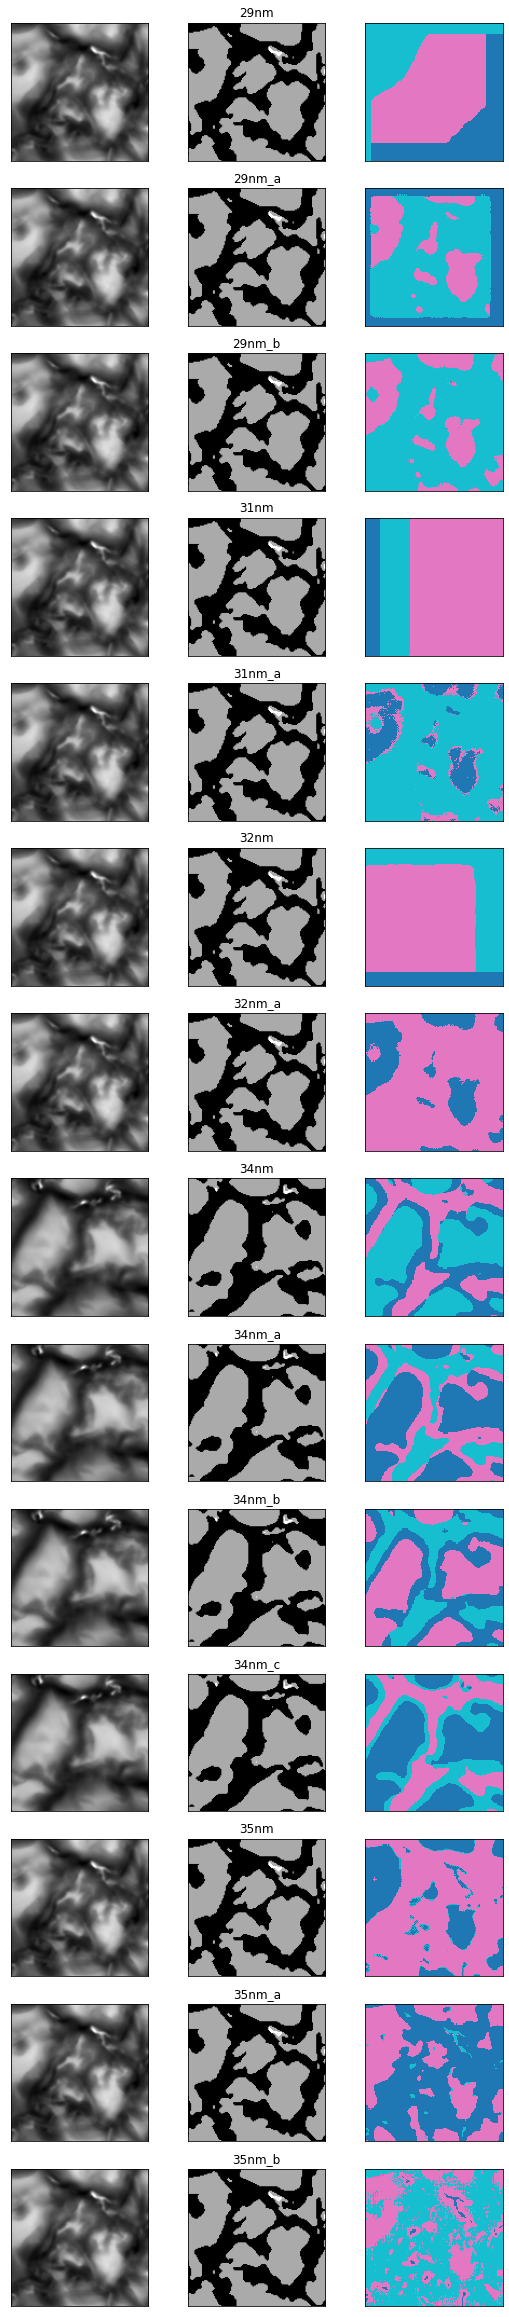

In [7]:
'''
Compare models
'''
idx = 58 # 51, 131 # 161  # 131 # dont want to go through timeseries test sets to actually find the imageset that whose target image is idx 131 in the non-TS test set
ms = [n.replace('WNet','') for n in mods['WNet_name']] # ['29nm','29nm_a','32nm','32nm_a','33nm','34nm','34nm_a'] # models on properly normalized data!
fig, axs = plt.subplots(len(ms), 3, figsize=(9, 3*len(ms)))
for i in range(len(ms)):
    output_dir = f'../../WNet_runs/exp{ms[i]}/test_preds_MURaM'
    target_pos = 2 if ms[i]=='WNet15m' else 0
    im = np.load(f'{output_dir}/x_{idx}.npy')[target_pos] # index to get image
    true = np.load(f'{output_dir}/true_{idx}.npy')
    preds = np.squeeze(np.load(f'{output_dir}/pred_{idx}.npy'))
    if int(preds[40, 60]) == 0: # try to mostly have black be zero
        preds_copy = np.copy(preds)
        preds[preds_copy == 0.0] = 1
        preds[preds_copy == 1.0] = 0 
    axs[i,1].set_title(f'{ms[i]}')
    axs[i,0].imshow(im, cmap='gist_gray')
    axs[i,1].imshow(true, vmin=0, vmax=1.5, cmap='gist_gray')
    axs[i,2].imshow(preds, vmin=0, vmax=1.5, interpolation='none', cmap='tab10') #cmap='gist_gray')#cmap='tab10')
    axs[i,0].xaxis.set_tick_params(labelbottom=False); axs[i,0].yaxis.set_tick_params(labelleft=False); axs[i,0].set_xticks([]); axs[i,0].set_yticks([])
    axs[i,1].xaxis.set_tick_params(labelbottom=False); axs[i,1].yaxis.set_tick_params(labelleft=False); axs[i,1].set_xticks([]); axs[i,1].set_yticks([])
    axs[i,2].xaxis.set_tick_params(labelbottom=False); axs[i,2].yaxis.set_tick_params(labelleft=False); axs[i,2].set_xticks([]); axs[i,2].set_yticks([])
plt.savefig('ExamplePredictions_OneImage.png')

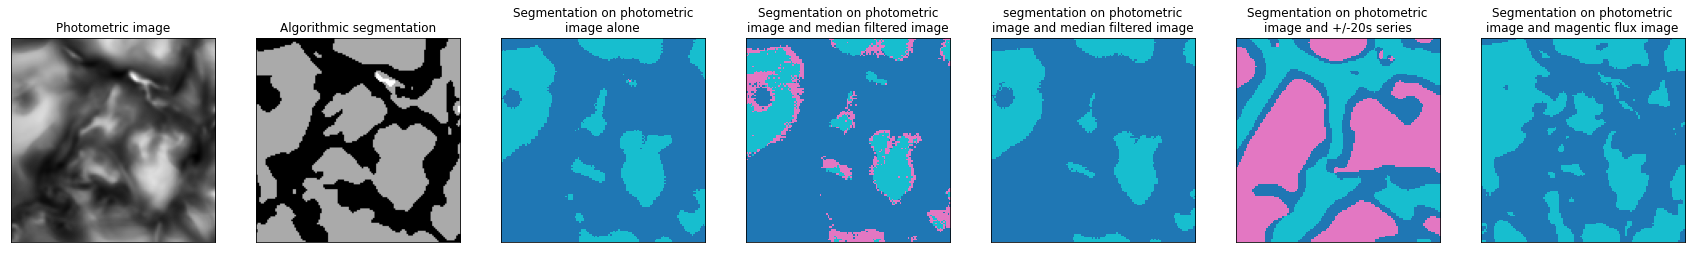

In [27]:
'''
Nice plots for poster
'''
ms = ['29nm_b','31nm_a','32nm_a','34nm_c','35nm_a']
descs = {'29nm_b':'Segmentation on photometric\nimage alone',
         '31nm_a':'Segmentation on photometric\nimage and median filtered image',
         '32nm_a':'Segmentation on photometric\nimage and median filtered image',
         '34nm_c':'Segmentation on photometric\nimage and +/-20s series',
         '35nm_a':'Segmentation on photometric\nimage and magentic flux image'}
tsidx = 58
idx = 58 # change this once script runs
im = np.load(f'../../WNet_runs/exp35nm/test_preds_MURaM/x_{idx}.npy')[0]
tru = np.load(f'../../WNet_runs/exp35nm/test_preds_MURaM/true_{idx}.npy')
fig, axs = plt.subplots(1, len(ms)+2, figsize=(6*len(ms),6))
axs[0].imshow(im, cmap='gist_gray')
axs[0].set_title('Photometric image')
axs[1].imshow(tru, vmin=0, vmax=1.5, cmap='gist_gray')
axs[1].set_title('Algorithmic segmentation')
for i in range(len(ms)):
    preds = np.squeeze(np.load(f'../../WNet_runs/exp{ms[i]}/test_preds_MURaM/pred_{idx}.npy'))
    # set dark blue for igr, light blue gr, pink bp
    preds_copy = np.copy(preds)
    if preds[0, 0] != 0.0: 
        igr_class = preds[0,0]
        preds[preds_copy == igr_class] = 0.0
    if preds[0, 127] != 1.0:
        gr_class = preds[0,127]
        preds[preds_copy == gr_class] = 1.0
    if preds[23, 75] != 1.5:
        bp_class = preds[23,75]
        preds[preds_copy == bp_class] = 1.5    
    axs[i+2].set_title(f'{descs[ms[i]]}')
    axs[i+2].imshow(preds, vmin=0, vmax=1.5, interpolation='none', cmap='tab10') #cmap='gist_gray')#cmap='tab10')
for ax in axs:
    ax.xaxis.set_tick_params(labelbottom=False); ax.yaxis.set_tick_params(labelleft=False); ax.set_xticks([]); ax.set_yticks([])
plt.savefig('ExamplePredictions_OneImage.png')


In [23]:
#np.where(tru==1.5)
print(tru[23,75|])

1.5


In [ ]:
'''
Run WNet in notebook for debugging
'''
sys.path.insert(0, '../')
import run_WNet
importlib.reload(data_utils)

if isinstance(exp_dicts, dict): # If experiment file is a single dict, not a list of dicts
    exp_dicts = [exp_dicts]
for d in exp_dicts:
    print(f'RUNNING EXPERIMENT {d["WNet_name"]} \nexp dict: {d}')
    run_wnet_model(d, args.gpu)
    print(f'DONE')
print('FINISHED ALL EXPERIMENTS')

#### Traditional 

In [ ]:
# Get data
path = "../Data/All_DKIST/FirstLight.fits"
data = fits.open(path)[0].data
labels = np.squeeze(fits.open("../Data/All_DKIST/SEGv2_FirstLight")[0].data) # just to check against

# Cut and flatten
data = data[100:300, 100:300]
labels = labels[100:300, 100:300]
dataflat = data.reshape(-1)

# Plot for comparison
plt.figure(figsize=(3, 3))
plt.imshow(data, cmap='gray', origin='lower')
plt.title('Initial data (HE)')
plt.figure()

# Create features and put into df (skip kernel feature for now - contain inf and probably not super useful anyway)
df = pd.DataFrame()
df['OG_value'] = dataflat
df = data_utils.add_gradient_feats(df, data) # Add value of (non-HE) gradient as feature
df = data_utils.add_sharpening_feats(df, dataflat) # Add value of sharpening filters as features RIGHT NOW JUST SQUARED

In [ ]:
'''
KMeans (best)
    Clusters by separating into n groups of equal variance, minimizing within-cluster sum-of-squares
    Overall, this seems to overestimate IGM
    Could try using large n_clusters, then combineing.
'''

from sklearn.cluster import KMeans

# Explore hyperparameters
n_clusterss = [2, 3, 5, 7]
inits = ['k-means++', 'random'] # can also try passing locs of centers if use another alg to determine

dict = {}
i = 0
for n_clusters in n_clusterss:
    for init in inits:
        preds_flat = KMeans(n_clusters=n_clusters, init=init, n_init=10).fit(df.values).labels_
        preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
        preds = data_utils.post_process(preds) # make sure IG is assigned to 0, G to 1
        dict[str(i)] = [n_clusters, init, preds]
        i += 1
        pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
        print('    n_clusters='+str(n_clusters)+', init='+str(init)+ ', "accuracy":', pct_correct)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle('KMeans')
axs = [ax1, ax2]
for i in range(len(axs)):
    n_clusters =  dict[str(i)][0]
    init = dict[str(i)][1]
    preds = dict[str(i)][2]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('n_clusters='+str(n_clusters)+', init='+str(init))


# With "best" hyperparameters
n_clusters = 7
preds_flat = KMeans(n_clusters=n_clusters, init='random', n_init=10).fit(df.values).labels_
preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))

def kmeans_to_seg(preds, data, resolution=0.016, bp_max_size=0.15):
    seg = np.zeros_like(data)*np.NaN
    # HE
    data_norm = ((data - np.nanmin(data))/(np.nanmax(data) - np.nanmin(data))) * 225 # min-max normalization to [0, 225] 
    data_HE = sk.filters.rank.equalize(data_norm.astype(int), footprint=sk.morphology.disk(250))
    data_HE = data_HE[100:300, 100:300]
    bp_min_pix = (bp_max_size / resolution)**2 # 87
    bp_min_flux = np.nanmean(data) + 0.25 * np.nanstd(data) 
    ig_max_flux = np.nanmean(data) - 0.25 * np.nanstd(data)
    labeled_preds = skimage.measure.label(preds + 1, connectivity=2)
    values = np.unique(labeled_preds) 
    for value in values:
        datavals = data[labeled_preds == value].flatten()
        if (np.nanmean(datavals) <= ig_max_flux):
            seg[labeled_preds == value] = 0
        if (np.nanmean(datavals) > ig_max_flux): #and (len(datavals) > bp_min_pix): #(np.nanmean(datavals) < bp_min_flux):
            seg[labeled_preds == value] = 1
            if (len(datavals) < bp_min_pix) and np.max(datavals) > bp_min_flux:
                seg[labeled_preds == value] = 1.5
    return seg

seg = kmeans_to_seg(preds, data)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.5))
fig.suptitle('KMeans (n_clusters=7, init="random")')
ax1.imshow(data, cmap='gray', origin='lower'); ax1.set_title('data')
ax2.imshow(preds, origin='lower'); ax2.set_title('kmeans preds')
ax3.imshow(seg, origin='lower'); ax3.set_title('kmeans pred -> seg')
fig, axs = plt.subplots(n_clusters, 1, figsize=(7, 2*n_clusters))
i = 0
axs[-1].set_ylabel('Flux')
for group in np.unique(preds):
    axs[i].hist(data[preds == group], bins=20); axs[i].set_ylabel(f'Group {i}')
    i += 1


In [ ]:
'''
Agglomorative Clustering
    Build clusters by finding closest pairs, merging iteratively 
    Does best with 3 clusters, 'complete' linkage, 'euclidean' metric:
    Without gradient feature, 3rd cluster becomes rings around granules, not brightpoints
    With gradient feature, maybe finds dim middles?
'''

from sklearn.cluster import AgglomerativeClustering

# Explore hyperparameters
n_clusterss = [2, 3] 
metrics = ['euclidean'] #  'l1', 'manhattan' seem to do similarly (at least with n_clusters=2) 
linkages = ['complete', 'ward'] # 'average' and 'single' do terrible

dict = {}
i = 0
for n_clusters in n_clusterss:
    for metric in metrics:
        for linkage in linkages:
            preds_flat = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage).fit(df.values).labels_
            preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
            preds = data_utils.post_process(preds) # make sure IG is addigned to 0, G to 1
            dict[str(i)] = [n_clusters, metric, linkage, preds]
            i += 1
            pct_correct = len(np.where(preds.reshape(-1)==labels.reshape(-1))[0])/len(preds.reshape(-1))
            print('    n_clusters='+str(n_clusters)+', linkage='+str(linkage)+ ', "accuracy":', pct_correct)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
fig.suptitle('AgglomorativeClustering')
axs = [ax1, ax2]
for i in range(len(axs)):
    n_clusters =  dict[str(i)][0]
    metric = dict[str(i)][1]
    linkage = dict[str(i)][2]
    preds = dict[str(i)][3]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('n_clusters='+str(n_clusters)+', linkage='+str(linkage))

In [ ]:
'''
DBSCAN 
    Clusters by identifying areas of high density separated by areas of low density 
    MUCH faster than OPTICS, but same very "poor" results
'''

from sklearn.cluster import DBSCAN

# Explore hyperparameters
epss = [10, 30] # must be larger for more features (0.5 works fine for 1 feature)
min_sampless = [50, 100, 200]
metric = 'euclidean'
algorithm = 'auto'

dict = {}
i = 0
for eps in epss:
    for min_samples in min_sampless:
        preds_flat = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm, n_jobs=3).fit(df.values).labels_
        preds = np.reshape(preds_flat, (np.shape(data)[0], np.shape(data)[1]))
        dict[str(i)] = [eps, min_samples, preds]
        i += 1

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('DBSCAN', color='white')
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in range(len(axs)):
    eps =  dict[str(i)][0]
    min_samples = dict[str(i)][1]
    preds = dict[str(i)][2]
    axs[i].imshow(preds, origin='lower')
    axs[i].set_title('eps='+str(eps)+', min_samps='+str(min_samples), color=tc)